# LTCF application

```{cointents} Table of Contents
:depth: 3
```


"https://academic.oup.com/cid/article/74/1/113/6370508#google_vignette"

LTCFs have a high burden of norovirus outbreaks. Most LTCF norovirus outbreaks occurred during winter months and were spread person-to-person. Outbreak surveillance can inform development of interventions for this vulnerable population, such as vaccines targeting GII.4 norovirus strains.

For every 1000 cases, there were 21.6 hospitalizations and 2.3 deaths.


"https://www.sciencedirect.com/science/article/pii/S1755436523000075"




## Guided model building 

1. What populations should we consider?
2. Is this type of pathogen seasonal and recurring?
3. Do we expect different rates of commuting between specific populations? 
4. Can we visualize our model?
5. Can we write down the system of differential equations?
6. Can we code it?
7. Can we infer anything important from our model results? 


## Focusing first on movement of individuals

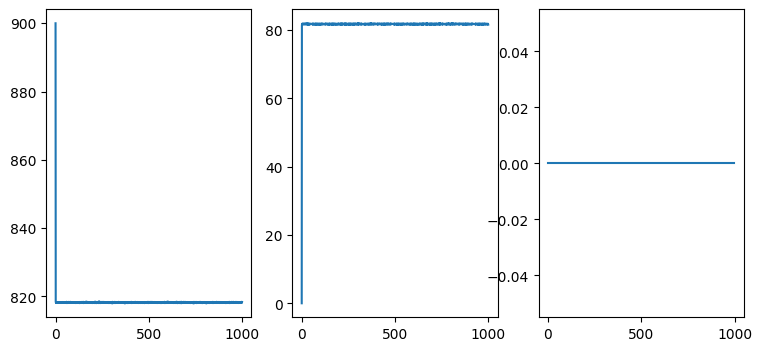

In [16]:

import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt


#-Population X is residents of a LTCF (Location X is the LTCF))
#-Population Y is clinical staff      (Location Y is the hospital)



def model():
    def metapop(t, y
                    ,new_resident_enters_ltcf
                    ,new_clinician_is_hired
                    ,residents_come_back_from_hospital
                    ,residents_go_to_hospital
                    ,clinicians_come_back_to_hospital
                    ,clinicians_go_to_LTCF):
        Nxx,Nxy,Nxz, Nyy, Nyx,Nyz, Nzz, Nzx, Nzy = y

       
        #-- This piece first-----------------------------------------------------------------------
        #--residents of LTCF
        dNxx_dt    = residents_come_back_from_hospital * Nxy - residents_go_to_hospital * Nxx - resident_and_staff_mingle*Nxx + resident_no_long_mingles*Nxz
        dNxy_dt    = -residents_come_back_from_hospital * Nxy + residents_go_to_hospital * Nxx
        dNxz_dt    = resident_and_staff_mingle*Nxx - resident_no_long_mingles*Nxz

        
        #--Clinical Staff
        dNyy_dt    = clinicians_come_back_to_hospital * Nyx - clinicians_go_to_LTCF * Nyy 
        dNyx_dt    = -clinicians_come_back_to_hospital * Nyx + clinicians_go_to_LTCF * Nyy
        dNyz_dt    = 0

        
        #--LTCF Staff
        dNzz_dt    = -resident_and_staff_mingle*Nzz + staff_to_staff*Nzx 
        dNzx_dt    = resident_and_staff_mingle*Nzz  - staff_to_staff*Nzx
        dNzy_dt    = 0
        
        #----------------------------------------------------------------------------------------
        
        return [ dNxx_dt, dNxy_dt, dNxz_dt
                ,dNyy_dt, dNyx_dt, dNyz_dt
                ,dNzz_dt, dNzx_dt, dNzy_dt ] 
    
    # Parameters
    new_resident_enters_ltcf = 0.#1./4
    new_clinician_is_hired   = 0.#1./52
    
    residents_come_back_from_hospital = 0#10.
    residents_go_to_hospital          = 0#1.

    clinicians_come_back_to_hospital  = 0#1.
    clinicians_go_to_LTCF             = 0#1.

    resident_and_staff_mingle         = 1
    resident_no_long_mingles          = 1
    staff_to_staff                    = 10
    
    
    Nxx, Nyy, Nzz                = 600, 10, 900   # Population sizes
    Nxy, Nxz, Nyx, Nyz, Nzx, Nzy =   0, 0, 0, 0, 0, 0 # Population sizes

    y0 = [Nxx,Nxy,Nxz,Nyy,Nyx,Nyz,Nzz,Nzx,Nzy]
    
    # Time span
    t_span = (0, 500)  # 100 days
    t_eval = np.linspace(*t_span, (t_span[-1]-t_span[0])*2 )
    
    # Solve the system
    solution = solve_ivp(metapop
                         , t_span
                         , y0
                         , args   = (new_resident_enters_ltcf
                                    ,new_clinician_is_hired
                                    ,residents_come_back_from_hospital
                                    ,residents_go_to_hospital
                                    ,clinicians_come_back_to_hospital
                                    ,clinicians_go_to_LTCF)
                         , t_eval = t_eval)
    return solution 
    

# Plot results
fig,axs = plt.subplots( 1,3, figsize=(9, 4))

solution = model()


Nx = solution.y[6]
Ny = solution.y[7] 
Nz = solution.y[8] 

ax=axs[0]
ax.plot(Nx)

ax=axs[1]
ax.plot(Ny)

ax=axs[2]
ax.plot(Nz)


### Fixed points for just movement

We observed above that the dynamics quickly move towards a set number of values and then stay there. 
In other words, the number of individuals in each of the "locations" reach a steady state---a fixed point.

Lets see if we can figure out the fixed points **just** for the movement of individuals between two locations: locations "x" and "y". 
For this exercise it is enough to understand the number of individuals from location who stay there and who move to location y or 

\begin{align}
    \frac{dN_{xx} }{dt} &= -\alpha N_{xx} + \beta N_{xy} \\
    \frac{dN_{xy} }{dt} &=  \alpha N_{xx} - \beta N_{xy} \\
\end{align}

To find the fixed points we set these two derivaties to zero. 

\begin{align}
    -\alpha N_{xx} + \beta N_{xy} &=0 \\
    \alpha N_{xx} - \beta N_{xy}  &=0 \\
\end{align}

and find that 

\begin{align}
    N_{xx}  = \frac{\beta}{\alpha} N_{xy}
\end{align}

This isnt a single point.
Instead, this is an infinite number of fixed points. 
This is because the two derivatives above are redundant (ie we would arrive at the same solution above no matter which equation we solved). 

If we had another constraint on the number of individuals in XX and in XY then we could find a single, unique fixed point. 
We are forgetting an important constraint.

\begin{align}
    N_{x} = N_{xx} + N_{xy}
\end{align}

The number of individuals who originate from location $X$ must be the sum of those who stay in X and moved to Y. 

Lets see if we can use this constraint to help us. 

\begin{align}
    N_{xx}  &= \frac{\beta}{\alpha} N_{xy} \\ 
            &= \frac{\beta}{\alpha} \left( N_{x} - N_{xx} \right)\\
   (1 + \frac{\beta}{\alpha})N_{xx}  &= \frac{\beta}{\alpha} N_{x} \\ 
   N_{xx} &= \frac{ \frac{\beta}{\alpha} N_{x} }{ (1 + \frac{\beta}{\alpha})} \\ 
   N_{xx} &= \left(\frac{\beta }{ \alpha + \beta}\right) N_{x} 
\end{align}

We find that the rate of movement to location Y $(\alpha)$ and the rate of movement back to $X$ ($\beta$) result in a fixed point such that there is a constant proportion $(\beta / (\alpha + \beta))$ of individuals in $N_{xx}$ and a proportion $(\alpha / (\alpha + \beta))$ of individuals in $N_{xy}$.

**How can we use this information?**
Rather than ask for the rate of movement of individuals between the LTCF and hospital, we can ask "what proportion of your clinical staff is assigned to the LTCF for any given time period?".



In [15]:
# import numpy as np
# from scipy.integrate import solve_ivp
# import matplotlib.pyplot as plt


# #-Population X is residents of a LTCF (Location X is the LTCF))
# #-Population Y is clinical staff      (Location Y is the hospital)



# def vary_rho(rho):
#     def sir_two_populations(t, y, beta
#                             ,gamma_clinician
#                             ,gamma_resident
#                             ,new_resident_enters_ltcf
#                             ,new_clinician_is_hired
#                             ,residents_come_back_from_hospital
#                             ,residents_go_to_hospital
#                             ,clinicians_come_back_to_hospital
#                             ,clinicians_go_to_LTCF):
#         Sxx,Sxy,Syx,Syy,Ixx,Ixy,Iyx,Iyy,  Nxx,Nxy,Nyx,Nyy = y

#         #--LTCF (Resdients) Population------------------------------------------------------------------------------------------------------------------------------
#         dSxx_dt = (new_resident_enters_ltcf)*Nxx-beta * Sxx * (Ixx + Iyx)/( Nxx + Nyx )   + residents_come_back_from_hospital*Sxy - residents_go_to_hospital*Sxx 
#         dSxy_dt = (new_resident_enters_ltcf)  *Nxy-beta * Sxy * (Iyy + Ixy)/( Nyy + Nxy ) - residents_come_back_from_hospital*Sxy + residents_go_to_hospital*Sxx

#         dIxx_dt = beta * Sxx * (Ixx + Iyx)/( Nxx + Nyx ) + residents_come_back_from_hospital*Ixy - residents_go_to_hospital*Ixx - gamma_resident*Ixx
#         dIxy_dt = beta * Sxy * (Iyy + Ixy)/( Nyy + Nxy ) - residents_come_back_from_hospital*Ixy + residents_go_to_hospital*Ixx - gamma_resident*Ixy
        
#         #--Clinicians Population------------------------------------------------------------------------------------------------------------------------------        
#         dSyx_dt = new_clinician_is_hired*Nyx-beta * Syx * (Ixx + Iyx)/( Nxx + Nyx ) - clinicians_come_back_to_hospital*Syx + clinicians_go_to_LTCF*Syy
#         dSyy_dt = new_clinician_is_hired*Nyy-beta * Syy * (Iyy + Ixy)/( Nyy + Nxy ) + clinicians_come_back_to_hospital*Syx - clinicians_go_to_LTCF*Syy

#         dIyx_dt = beta * Syx * (Ixx + Iyx)/( Nxx + Nyx ) - clinicians_come_back_to_hospital*Iyx + clinicians_go_to_LTCF*Iyy - gamma_clinician*Iyx
#         dIyy_dt = beta * Syy * (Iyy + Ixy)/( Nyy + Nxy ) + clinicians_come_back_to_hospital*Iyx - clinicians_go_to_LTCF*Iyy - gamma_clinician*Iyy
        
#         #-- This piece first-----------------------------------------------------------------------
#         #--residents of LTCF
#         dNxx_dt    = residents_come_back_from_hospital * Nxy - residents_go_to_hospital * Nxx
#         dNxy_dt    = -residents_come_back_from_hospital * Nxy + residents_go_to_hospital * Nxx

#         #--Clinical Staff
#         dNyy_dt    = clinicians_come_back_to_hospital * Nyx - clinicians_go_to_LTCF * Nyy 
#         dNyx_dt    = -clinicians_come_back_to_hospital * Nyx + clinicians_go_to_LTCF * Nyy
#         #----------------------------------------------------------------------------------------
        
#         return [ dSxx_dt, dSxy_dt, dSyx_dt, dSyy_dt
#                , dIxx_dt, dIxy_dt, dIyx_dt, dIyy_dt
#                , dNxx_dt, dNxy_dt, dNyx_dt, dNyy_dt] 
    
#     # Parameters
#     beta      = 0.7             # Infection rate
#     gamma_clinician  = 0.5      # Recovery rate
#     gamma_resident   = 0.25     # Recovery rate
    
#     new_resident_enters_ltcf = 0.#1./4
#     new_clinician_is_hired   = 0.#1./52
    
#     residents_come_back_from_hospital = 4.
#     residents_go_to_hospital          = 1.

#     clinicians_come_back_to_hospital  = 1.
#     clinicians_go_to_LTCF             = 1.
    
#     Nxx, Nyy = 1000, 10  # Population sizes
#     Nxy, Nyx =    0, 0 # Population sizes

#     # Initial conditions
#     Sxx,Sxy,Syx,Syy = 999,0,0,10
#     Ixx,Ixy,Iyx,Iyy = 1,0,0,0

#     y0 = [Sxx,Sxy,Syx,Syy,Ixx,Ixy,Iyx,Iyy,Nxx,Nxy,Nyx,Nyy]
    
#     # Time span
#     t_span = (0, 500)  # 100 days
#     t_eval = np.linspace(*t_span, (t_span[-1]-t_span[0])*2 )
    
#     # Solve the system
#     solution = solve_ivp(sir_two_populations
#                          , t_span
#                          , y0
#                          , args   = (beta
#                                     ,gamma_clinician
#                                     ,gamma_resident
#                                     ,new_resident_enters_ltcf
#                                     ,new_clinician_is_hired
#                                     ,residents_come_back_from_hospital
#                                     ,residents_go_to_hospital
#                                     ,clinicians_come_back_to_hospital
#                                     ,clinicians_go_to_LTCF)
#                          , t_eval = t_eval)
#     return solution 
    

# # Plot results
# fig,ax = plt.subplots( 1,1, figsize=(9, 4))

# solution = vary_rho(0)

# Ix = solution.y[4] + solution.y[5]
# Iy = solution.y[6] + solution.y[7]

# ax.plot(solution.t[:200], Ix[:200]/1000 , label='I1 (Population 1)')
# ax.set_ylim(0,0.40)

# ax.plot(solution.t[:200], Iy[:200]/10,  label='I2 (Population 2)', linestyle='dashed')